<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# Combinations of planar potential flows
In this notebook we will discuss combinations of the elementary potential flows.

We can easily make combinations of potential flows, simply by adding them.
This is because the governing equations for potential flow are linear. So,
for example, if $\phi_1$ and $\phi_2$ are both solutions of Laplace's equation,
then so is $\phi_3 = \phi_1 + \phi_2$:

$$\nabla^2\phi_3 = \nabla^2(\phi_1 + \phi_2) = \nabla^2\phi_1 + \nabla^2\phi_2 = 0$$

### Set up the module

In [1]:
using FluidDynTools

In [2]:
using PotentialFlow
using ViscousFlow

In [3]:
using Plots

### Set up grids and grid data for visualizing the potential flows
To see these flows, we need to evaluate them on a grid of points. As we
discussed in the previous notebook, it is most convenient to evaluate these
using complex coordinates. So here, we will set up grids of complex coordinates
for evaluating the different flow types.

First make the grid itself

In [4]:
# grid cell size
Δx = 0.02

# set the size of a region in which to set up the flow.
xlim = (-2,2)
ylim = (-2,2)

# make the grid
g = PhysicalGrid(xlim,ylim,Δx)

CartesianGrids.PhysicalGrid{2}((208, 210), (104, 105), 0.02, ((-2.06, 2.06), (-2.08, 2.08)), 10)

As in the previous notebook, create a cache and some blank data

In [5]:
cache = GridCache(g)
ψ = zeros_gridcurl(cache)
vel = zeros_gridgrad(cache);

Let's try a combination of a uniform flow at 0 degrees and a source at the origin of strength 2:

The uniform flow

In [6]:
U∞ = 1.0  ## speed
α = 0.0 ## angle in radians
fs = Freestreams.Freestream(U∞*exp(im*α))

PotentialFlow.Freestreams.Freestream(1.0 + 0.0im)

The source

In [7]:
zs = 0.0+im*0.0  ## location of the source
Q = 2.0  ## strength of the source
s = Source.Point(zs,Q)

Source.Point(0.0 + 0.0im, 2.0)

We will add these, but take some care to use our rotation trick on the branch cut
of the source, so that it is along the $+x$ axis.

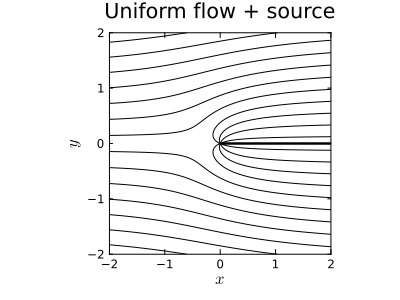

In [8]:
ψ .= ViscousFlow.streamfunction(fs,cache) + ViscousFlow.streamfunction(s,cache,angle=0)
p = plot(ψ,cache,color=:black,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Uniform flow + source")

There is a **stagnation point** in this flow somewhere to the left of the source,
and this indicates that **stagnation streamlines** cross there.

To include the stagnation streamline to the plot, we can find the value of streamfunction
at the stagnation point. This is the value it will have on the entire stagnation streamlines.

In this example, we can find the location of the stagnation point by hand, using the
polar velocity components from the flow:

$$ u_r = U_\infty \cos\theta + \dfrac{Q}{2\pi r}, \quad u_\theta = 0 $$

The stagnation point is at $\theta = \pi$ and $r = a = Q/(2\pi U_\infty)$. In Cartesian
coordinates, this is $x = -Q/(2\pi U_\infty)$ and $y = 0$.

To evaluate the streamfunction at a specific point, we first turn the grid of
streamfunction values into a function of $x$ and $y$.

In [9]:
ψfield = interpolatable_field(ψ,g);

Now evaluate $\psi$ at the stagnation point:

In [10]:
xstag = -Q/(2π*U∞)
ystag = 0
ψstag = ψfield(xstag,ystag)

3.8828627921927464e-17

Now add a streamline with this value of $\psi$ to the plot:

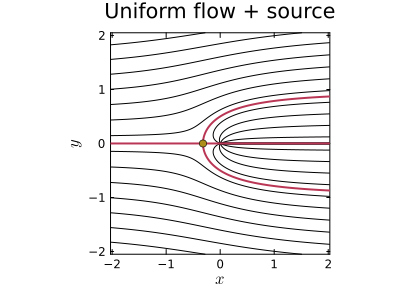

In [11]:
p = plot(ψ,cache,color=:black,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Uniform flow + source")
plot!(p,ψ,cache,levels=[ψstag],linewidth=2)
scatter!(p,[xstag],[ystag],label="stagnation point")

### Another combination: two vortices
The tools provided in `PotentialFlow` do not require us to explicitly add the
flows; it does it for us. This is especially useful with a lot of vortices. Let us
try two point vortices, and place them at $(-1,0)$ and $(1,0)$, and give them strengths
$1$ and $-1$:"

First create empty arrays

In [12]:
zvort = ComplexF64[]
Γvort = Float64[]

Float64[]

Add the first vortex to the array

In [13]:
push!(zvort,-1.0+0im)
push!(Γvort,1.0)

1-element Vector{Float64}:
 1.0

add the second vortex to the array

In [14]:
push!(zvort,1.0+0im)
push!(Γvort,-1.0)

2-element Vector{Float64}:
  1.0
 -1.0

Now make the list of vortices. Note the . after `Vortex.Point`, which is needed to create
an array of point vortices

In [15]:
v = Vortex.Point.(zvort,Γvort)

2-element Vector{PotentialFlow.Points.Point{Float64, Float64, Val{Inf}}}:
 Vortex.Point(-1.0 + 0.0im, 1.0)
 Vortex.Point(1.0 + 0.0im, -1.0)

Visualize with the usual plot

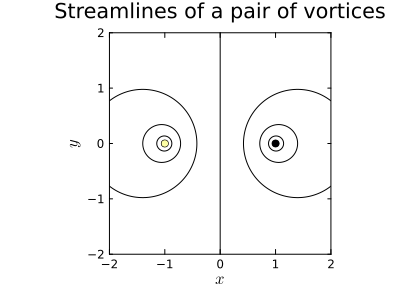

In [16]:
ViscousFlow.streamfunction!(ψ,v,cache)
p = plot(ψ,cache,color=:black,levels=range(-1,1,length=15),xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Streamlines of a pair of vortices",show=true)
plot!(p,v) ## This adds markers for the vortices

Let's evaluate the velocity at the origin, which is a convenient point on the
vertical line in the middle. For this, we use the `induce_velocity` function.
(The last argument is time, which is irrelevant, so we just set it to zero.)

In [17]:
z_eval = 0.0+0.0*im
induce_velocity(z_eval,v,0.0)

0.0 + 0.3183098861837907im

The real part ($u$) is zero (as expected on this line of symmetry) and the imaginary part
 ($v$) is positive, indicating an **upward flow** between the two vortices.

### Another combination: several vortices
"The tools provided in `PotentialFlow` do not require us to explicitly add the flows;
it does it for us. This is especially useful with a lot of vortices. Let's try to make
a circular **vortex patch**. This is formed from a collection of point vortices arranged
in concentric rings. Each vortex will have the same strength.

Create one patch at $(-1,0)$ with strength 1

In [18]:
xcent = -1.0
ycent = 0.0
Γ = 1.0
R = 0.5
nring = 5

v1 = vortex_patch(xcent,ycent,Γ,R,nring);

and another patch at $(1,0)$ with strength -1

In [19]:
xcent = 1.0
ycent = 0.0
Γ = -1.0
R = 0.5
nring = 5

v2 = vortex_patch(xcent,ycent,Γ,R,nring);

We can combine them easily into something called a **tuple**

In [20]:
vortex_system = (v1,v2);

Now plot them

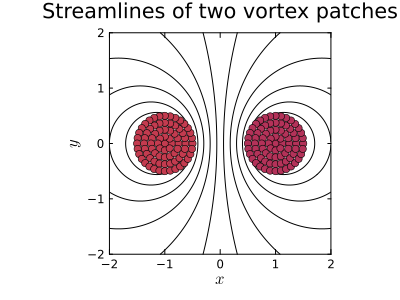

In [21]:
ViscousFlow.streamfunction!(ψ,vortex_system,cache)
p = plot(ψ,cache,color=:black,xlim=(-2,2),ylim=(-2,2),xlabel=L"x",ylabel=L"y",title="Streamlines of two vortex patches",show=true)
plot!(p,vortex_system)

We can evaluate the velocity of this system at any point, e.g.,

In [22]:
z_eval = 0.0+0.0*im
induce_velocity(z_eval,vortex_system,0.0)

-6.965998958219366e-18 + 0.3183098881072014im

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*